# LLM Zoomcamp - Week 2 Notes

In the second week, we set up cloud-based GPU options like SaturnCloud and explore open source alternatives to OpenAI platforms and  models like:
Platforms:
- HuggingFace
- Ollama
- SaturnCloud

Models:
- Google FLAN T5
- Phi 3 Mini
- Mistral 7-B

And finally, we put the RAG we built in week 1 into a Streamlit UI

A few important call outs for this section:
- For the most part, I will be taking these notes in a Saturn Cloud notebook
- Which means that before starting each note section, I will be restarting the kernel to free up RAM from the GPU I'm using
- So if I ever decide to revisit these notes in the future, I won't be able to just load this notebook and run things as is

In [1]:
import os
import requests

## 2.2 Using SaturnCloud for GPU Notebooks
- The main thing not covered is how to give Saturn Cloud access to your GitHub repositories
    - This is fairly straightforward:
        1. In Saturn Cloud, go to "Manage <username>" and create an SSH key pair
        2. Copy the public key Saturn Cloud generates and go to Github.com
            i. In Github.com, go to Settings -> SSH and GPG keys and click on `New SSH Key`
            ii. Paste in the public key you copied from Saturn Cloud
        3. Now go back to Saturn Cloud and click on `Git Repositories`
            i. Click on `New`
            ii. Add the url for the Github repository you want Saturn Cloud to have access to
- When creating a new Python VM resource, make sure to install additional libs: `pip install -U transformers accelerate bitsandbytes`
- The rest of it is quite straightforward
- A few things I did with my setup of the notebook resource that just helps with development:
    1. I enabled SSH access so that I can ideally connect to this notebook resource in VS Code (and thus take advantange of many things including Github Copilot)
    2. I gave the VM an easy to remember name: https://llm-zoomcamp-waleed.community.saturnenterprise.io
    3. I created an access token on huggingface.co and added it as an environment variable on Saturn Cloud (more on that in section 2.5)

## 2.3 HuggingFace and Google FLAN T5

- In this lesson, we start working with open source models available on [HuggingFace](huggingface.co)
    - HuggingFace is a place where people host models, not just LLMs, all kinds of ML models (which effectively boils down to hosting model weights)
- This is where our Saturn Cloud GPU notebook in 2.2 comes into play as we'll need a GPU to work with these models
- We're going to be using Google FLAN T5: https://huggingface.co/google/flan-t5-xl

Let's start by pulling in the minsearch engine we're going to use in our RAG

In [8]:
!rm -f minsearch.py
!wget https://raw.githubusercontent.com/alexeygrigorev/minsearch/main/minsearch.py

--2024-07-08 01:20:41--  https://raw.githubusercontent.com/alexeygrigorev/minsearch/main/minsearch.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3832 (3.7K) [text/plain]
Saving to: ‘minsearch.py’

minsearch.py        100%[===================>]   3.74K  --.-KB/s    in 0s      

2024-07-08 01:20:41 (83.2 MB/s) - ‘minsearch.py’ saved [3832/3832]



From the link above, we have some reference code to run the model on a GPU:

```python
# pip install accelerate
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Import a tokenizer to convert text to tokens
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-xl")
# Load the model
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-xl", device_map="auto")

input_text = "translate English to German: How old are you?"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")

outputs = model.generate(input_ids)
print(tokenizer.decode(outputs[0]))
```

- An important consideration is how Saturn Cloud provisions storage
    - By default, HuggingFace wants to use a /cache subdirectory within the /home directory in your Saturn Cloud environment
        - You can change this by setting the `HF_HOME` environment variable
        - A better way to do this would be to set it using `direnv` (helpful blog post on that [here](https://waleedayoub.com/post/managing-dev-environments_local-vs-codespaces/#option-2-github-codespaces))
    ```python
    import os
    os.environ['HF_HOME']='/run/cache'import os
    os.environ['HF_HOME']='/run/cache'
    ```
    - The main change we make to our original FAQ answering RAG is the `def llm(query):` function
    ```python
    def llm(prompt):
        input_text = prompt
        input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")
        outputs = model.generate(input_ids)
        results = tokenizer.decode(outputs[0])
        
        return results
    ```
    - By default, FLAN T5's `generate` method caps the length of the response. You can actually check what the max length is with this:
    ```python
    print(f"Default max_length: {model.config.max_length}")
    ```
    - This returns: Default max_length: 20
    - So this can easily be changed when calling the `generate` method like this:
    ```python
    outputs = model.generate(input_ids, max_length=200)
    ```
    - Another useful parameter to the `decode` method is passing `skip_special_tokens` which seems to get rid of the padding leading and trailing tokens
    ```python
    results = tokenizer.decode(outputs[0], skip_special_tokens=True)
    ```    

### So let's put it all together now and modify our RAG from section 1 to use FLAN T5!

In [2]:
import os
os.environ['HF_HOME']='/run/cache'

In [3]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [4]:
# Import a tokenizer to convert text to tokens
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-xl")
# Load the model
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-xl", device_map="auto")

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/53.0k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [5]:
input_text = "translate English to German: How old are you?"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")

In [6]:
print(input_ids)

tensor([[13959,  1566,    12,  2968,    10,   571,   625,    33,    25,    58,
             1]], device='cuda:0')


In [7]:
outputs = model.generate(input_ids)
print(outputs)
print(tokenizer.decode(outputs[0]))

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


tensor([[   0, 2739, 4445,  436,  292,   58,    1]], device='cuda:0')
<pad> Wie alt sind Sie?</s>


### Now we do the same RAG as before but we modify the llm function to use our local FLAN T5 weights vs an OpenAI API call

In [9]:
import requests 
import minsearch

docs_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main/01-intro/documents.json?raw=1'
docs_response = requests.get(docs_url)
documents_raw = docs_response.json()

documents = []

for course in documents_raw:
    course_name = course['course']

    for doc in course['documents']:
        doc['course'] = course_name
        documents.append(doc)

index = minsearch.Index(
    text_fields=["question", "text", "section"],
    keyword_fields=["course"]
)

index.fit(documents)

In [9]:
def search(query):
    boost = {'question': 3.0, 'section': 0.5}

    results = index.search(
        query=query,
        filter_dict={'course': 'data-engineering-zoomcamp'},
        boost_dict=boost,
        num_results=5
    )

    return results

In [10]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

def llm(prompt):
    input_text = prompt
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")
    outputs = model.generate(input_ids, max_length=200)
    results = tokenizer.decode(outputs[0])
    
    return results

In [14]:
def rag(query):
    search_results = search(query)
    prompt = build_prompt(query, search_results)
    answer = llm(prompt)
    return answer

In [12]:
rag("I just discovered the course, can I still register?")

"<pad> Yes, even if you don't register, you're still eligible to submit the homeworks. Be aware, however, that there will be deadlines for turning in the final projects. So don't leave everything for the last minute.</s>"

In [13]:
print(f"Default max_length: {model.config.max_length}")

Default max_length: 20


## 2.4 Phi 3 Mini
- Not a lot of notes to take here
- We just replaced the FLAN T5 implementation in the previous section with the Microsoft Phi 3 Mini implementation:
    - You can find that model here: https://huggingface.co/microsoft/Phi-3-mini-128k-instruct
- I'm not going to bother reproducing all the same code for the Phi3 model and will instead focus on the next section using Mistral7B

## 2.5 Mistral-7B and HuggingFace Hub Authentication
- For this lesson, we'll be using this model from HuggingFace: https://huggingface.co/mistralai/Mistral-7B-v0.1https://huggingface.co/mistralai/Mistral-7B-v0.1
- The documentation there is pretty sparse, but luckily HuggingFace's own "generation with LLM's" tutorial page uses this model in its example: https://huggingface.co/docs/transformers/en/llm_tutorialhttps://huggingface.co/docs/transformers/en/llm_tutorial
    - One of the things you'll encounter on HuggingFace are models that are gated: 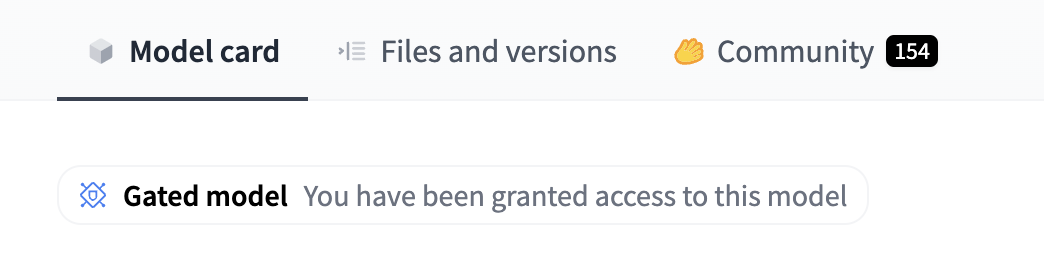
    - In order to have access to these models, you need authenticate your account by creating an access token on HuggingFace and adding it as an environment variable wherever you need to use it
    - Thankfully, in section 2.1 above, I had already created an access token on HuggingFace and added it as an environment variable here in SaturnCloud as `HF_TOKEN`
    - To login using that token, you would do this use a function from `huggingface_hub` and pass it the token
    - One thing to make sure of is that you have all the right permissions for the respective HuggingFace repo where the model is stored. To do this, select the access token and edit its permissions

In [3]:
from huggingface_hub import login

In [5]:
login(token = os.environ['HF_TOKEN'])

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /run/cache/token
Login successful


### And now we can dump in all the code needed to use the Mistral7B model

In [6]:
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer

In [7]:
model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-v0.1", device_map="auto", load_in_4bit=True
)

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1", padding_side="left")

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

### Now to use the model to generate an output, we use the following code

```python
# create the inputs
model_inputs = tokenizer(['A list of colours: blue, red, pink'], return_tensors="pt").to("cuda")

generated_ids = model.generate(**model_inputs)
tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
```

### But, before we do that, we're going to have to make some modifications to our RAG in order to ensure this model works effectively
1. Use the `pipeline` function from HuggingFace's `tranformers` library to abstract how we use this model
    - I don't know exactly what magic happens under `pipeline`'s hood, but it seems to be aware of particular models complex needs
    - So instead of using the `tokenizer` and `model.generate` above, we first create a `generator` object using `pipeline`:
    ```python
    generator = pipeline("text-generation", model = model, tokenizer = tokenizer
    ```
    - Then in the llm function, we use `generator` to generate our output
2. This model is a completion model, so it passes the whole context back to you. Which means it's highly sensitive to the context you pass it. So, we're going to need to simplify the context
3. Another thing we'll need to do is limit the responses we get back from our search engine as that too is part of the context we pass it
- When using the actual model, we're going to have to pass some parameters to ensure we get good results:
    - `max_length`: Make this big but not too big :/
    - `temperature`: Adjust the temperature to less than 1.0 to reduce randomness
    - `top_p`: Implements nucleus sampling, which chooses from the smallest set of tokens whose cumulative probability exceeds p.
    - `num_return_sequences`: Indicates that only one sequence should be returned.
4. Filter the output to exclude the initial prompt

In [10]:
# Return only 3 results this time
def search(query):
    boost = {'question': 3.0, 'section': 0.5}

    results = index.search(
        query=query,
        filter_dict={'course': 'data-engineering-zoomcamp'},
        boost_dict=boost,
        num_results=3
    )

    return results

In [11]:
# Use the pipeline method to abstract our usage of Mistral7B
from transformers import pipeline
generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

In [12]:
# Finally, change the way the prompt is constructed:

def build_prompt(query, search_results):
    prompt_template = """
QUESTION: {question}

CONTEXT:
{context}

ANSWER:
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"{doc['question']}\n{doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

def llm(prompt):
    response = generator(prompt, max_length=500, temperature=0.7, top_p=0.95, num_return_sequences=1)
    response_final = response[0]['generated_text']
    return response_final[len(prompt):].strip()

In [15]:
rag("I just discovered the course. Can I still join it?")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:540: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:545: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  war

'Yes, you can still join the course.'

And lastly, if we want to download these model weights to use them without having to authenticate with HuggingFace everytime, we can do so with the following:

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "mistralai/Mistral-7B-v0.1"

# Download and cache the model and tokenizer
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Save the model and tokenizer locally
model.save_pretrained("./mistral-7b-model")
tokenizer.save_pretrained("./mistral-7b-tokenizer")

And if we already have the model weights downloaded locally, we can load them without having to use HuggingFace like this:

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_dir = "./mistral-7b-model"
tokenizer_dir = "./mistral-7b-tokenizer"

# Load the model and tokenizer from the local directory
model = AutoModelForCausalLM.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_dir)

## 2.6 Exploring Open Source LLMs
- Not a whole lot of note taking here
- This lesson was just showcasing where to find other open source LLMs
- I think the crux of it is that you're always looking to pair the highest quality model with the hardware limitations of your machine
    - So the rule of thumb for us here is that a 7B - 9B parameter model generally fits within a 16G RAM GPU

## 2.7 Running LLMs Locally without a GPU with Ollama
- Now we start to use tools like [ollama](https://ollama.com/) to run models locally, with or without a GPU
- 